In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

seed = 3244
np.random.seed(seed)

h = 50  # height of image
w = 37  # width of image
aligned_h = h
aligned_w = h

num_classes = 7

Using TensorFlow backend.


In [2]:
X = np.load('X_train.npy') # (996, 1850)
y = np.load('y_train.npy') # (996, 1)

X_aligned = np.load('X_train_aligned.npy')
y_aligned = np.load('y_train_aligned.npy')

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train_aligned, X_test_aligned, y_train_aligned_raw, y_test_aligned_raw = train_test_split(X_aligned, y_aligned, test_size=0.2, random_state=seed)

In [3]:
def shapeData(data, h=h, w=w):
    return data.reshape(data.shape[0], 1, h, w).astype('float32')

def normalize(data):
    return data / 255

In [4]:
X = normalize(shapeData(X))

X_train = normalize(shapeData(X_train))
X_test = normalize(shapeData(X_test))

X_train_aligned = normalize(shapeData(X_train_aligned, h=aligned_h, w=aligned_w))
X_test_aligned = normalize(shapeData(X_test_aligned, h=aligned_h, w=aligned_w))

In [5]:
# one hot encode outputs
y = np_utils.to_categorical(y)

y_train = np_utils.to_categorical(y_train_raw)
y_test = np_utils.to_categorical(y_test_raw)

y_train_aligned = np_utils.to_categorical(y_train_aligned_raw)
y_test_aligned = np_utils.to_categorical(y_test_aligned_raw)

In [6]:
def baseline_model():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
num_filters = 32  # number of convolutional filters to use
pool_size = (2, 2)  # size of pooling area for max pooling
kernel_size = (5, 5)  # convolution kernel size

def model1():
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model2():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(Convolution2D(32, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # Note: Keras does automatic shape inference.
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def model3():
    model = Sequential()
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=(1, h, w)))
    model.add(Activation('relu'))
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model

def model4():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape=(1, h, w)))
    model.add(Convolution2D(64, 3, 3,  activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu")) # 4096
    model.add(Dense(num_classes, activation="softmax"))
    
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
    return model

def model5(h=h, w=w):
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, h, w), border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 5, 5, border_mode='valid', activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
# model = baseline_model()
# model = model1()
# model = model2()
# model = model3()
# model = model4()
model = model5()

nb_epoch = 40
batch_size = 50

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

y_pred = model.predict_classes(X_test)
f1_score(y_test_raw, y_pred, average='macro')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 46, 33)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 23, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 23, 16)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 19, 12)    51264       dropout_1[0][0]                  
___________________________________________________________________________________________

0.91628024597470004

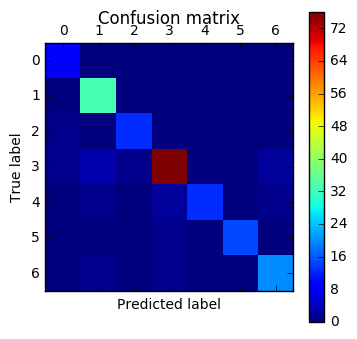

array([[ 9,  0,  0,  0,  0,  0,  0],
       [ 0, 33,  0,  0,  0,  0,  0],
       [ 1,  0, 13,  0,  0,  0,  0],
       [ 1,  3,  1, 76,  0,  0,  2],
       [ 0,  1,  0,  2, 13,  0,  1],
       [ 0,  0,  0,  1,  0, 15,  0],
       [ 0,  1,  0,  1,  0,  0, 20]])

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_raw, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
cm

In [10]:
model = model5(h=aligned_h, w=aligned_w)

model.fit(X_train_aligned, y_train_aligned, 
          validation_data=(X_test_aligned, y_test_aligned),
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

y_pred_aligned = model.predict_classes(X_test_aligned)
f1_score(y_test_aligned_raw, y_pred_aligned, average='macro')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 46, 46)    832         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 23, 23)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 23, 23)    0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 64, 19, 19)    51264       dropout_3[0][0]                  
___________________________________________________________________________________________

0.94005898947854483

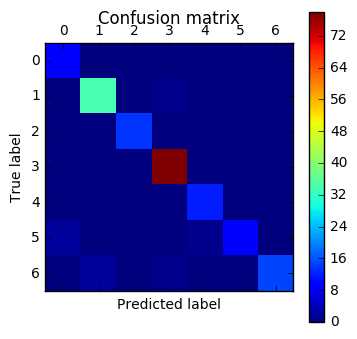

array([[10,  0,  0,  0,  0,  0,  0],
       [ 0, 34,  0,  1,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0],
       [ 0,  0,  0, 78,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0],
       [ 2,  0,  0,  0,  1,  9,  0],
       [ 0,  2,  0,  1,  0,  0, 15]])

In [11]:
cm = confusion_matrix(y_test_aligned_raw, y_pred_aligned)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
cm

In [12]:
full_model = model5()
full_model.fit(X, y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 32, 46, 33)    832         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 32, 23, 16)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 32, 23, 16)    0           maxpooling2d_5[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 64, 19, 12)    51264       dropout_5[0][0]                  
___________________________________________________________________________________________

In [16]:
X_aligned = normalize(shapeData(X_aligned, h=aligned_h, w=aligned_w))
y_aligned = np_utils.to_categorical(y_aligned)

full_model_aligned = model5(h=aligned_h, w=aligned_w)
full_model_aligned.fit(X_aligned, y_aligned, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_11 (Convolution2D) (None, 32, 46, 46)    832         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 32, 23, 23)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 32, 23, 23)    0           maxpooling2d_11[0][0]            
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 64, 19, 19)    51264       dropout_11[0][0]                 
___________________________________________________________________________________________

In [18]:
X_test_given = normalize(shapeData(np.load('X_test.npy')))
X_test_given_aligned = normalize(shapeData(np.load('X_test_aligned.npy'), h=aligned_h, w=aligned_w))

classes_unaligned = full_model.predict_classes(X_test_given)
classes_aligned = full_model_aligned.predict_classes(X_test_given_aligned)

prob_unaligned = full_model.predict_proba(X_test_given)
prob_aligned = full_model_aligned.predict_proba(X_test_given_aligned)

306/306 [==============================] - 1s     


In [46]:
print(classes_unaligned)
print(classes_aligned)

[1 4 6 1 3 2 1 1 0 6 1 3 3 3 4 0 3 1 3 1 3 0 0 4 3 0 4 1 4 3 2 6 3 1 1 3 3
 6 3 6 3 6 3 1 3 5 2 2 3 3 3 3 3 3 4 2 1 5 4 0 6 4 2 3 4 3 1 3 3 3 2 3 3 2
 3 1 2 3 3 3 3 3 1 3 6 2 1 1 2 1 0 4 2 3 6 3 3 6 1 3 3 6 3 3 2 4 3 6 2 4 3
 3 0 0 3 3 6 5 2 3 2 0 5 3 6 3 3 1 2 4 2 5 3 1 5 3 1 2 3 3 1 6 1 3 3 1 3 2
 3 3 3 4 2 1 6 3 5 1 3 3 1 3 3 0 5 4 6 2 3 2 3 2 2 3 1 1 2 3 3 3 5 3 1 4 0
 6 4 1 3 5 1 5 6 3 3 3 2 3 1 4 3 2 3 3 3 2 3 3 1 2 0 0 6 6 2 1 3 2 3 3 1 6
 2 3 6 6 3 6 3 3 5 3 3 3 3 2 2 6 2 6 3 6 2 3 3 3 3 1 6 5 3 1 0 1 0 1 1 0 1
 2 3 4 3 3 3 3 4 1 3 6 1 3 4 3 3 3 6 1 1 1 3 3 3 6 4 3 0 2 3 3 3 3 6 3 6 3
 2 3 1 1 4 1 2 3 1 3 4 3 3 1 3 2 3 0 3 0 3 4 3 3 3 1]
[1 0 6 1 3 2 0 4 0 6 1 3 3 3 3 0 3 1 3 1 3 0 0 3 3 4 1 4 3 2 6 3 1 1 6 3 6
 3 6 3 6 3 1 3 3 2 2 3 3 3 6 3 3 4 2 1 5 4 0 6 0 2 2 4 2 1 3 3 3 3 3 3 2 3
 1 2 3 3 3 3 3 6 3 6 1 1 2 1 0 4 2 3 6 3 3 1 1 3 3 6 3 3 4 6 2 4 3 3 0 0 3
 3 6 5 3 3 2 0 5 3 6 5 0 2 4 3 3 1 1 3 1 2 3 3 1 6 1 3 3 1 6 2 3 3 3 4 4 1
 6 3 5 1 3 3 1 3 3 0 5 4 6 2 3 5 3 2 6 3 1 1 3

In [21]:
def plot_gallery(images, titles, h, w, n_row=10, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, i):
    return 'predicted: %s' % y_pred[i]

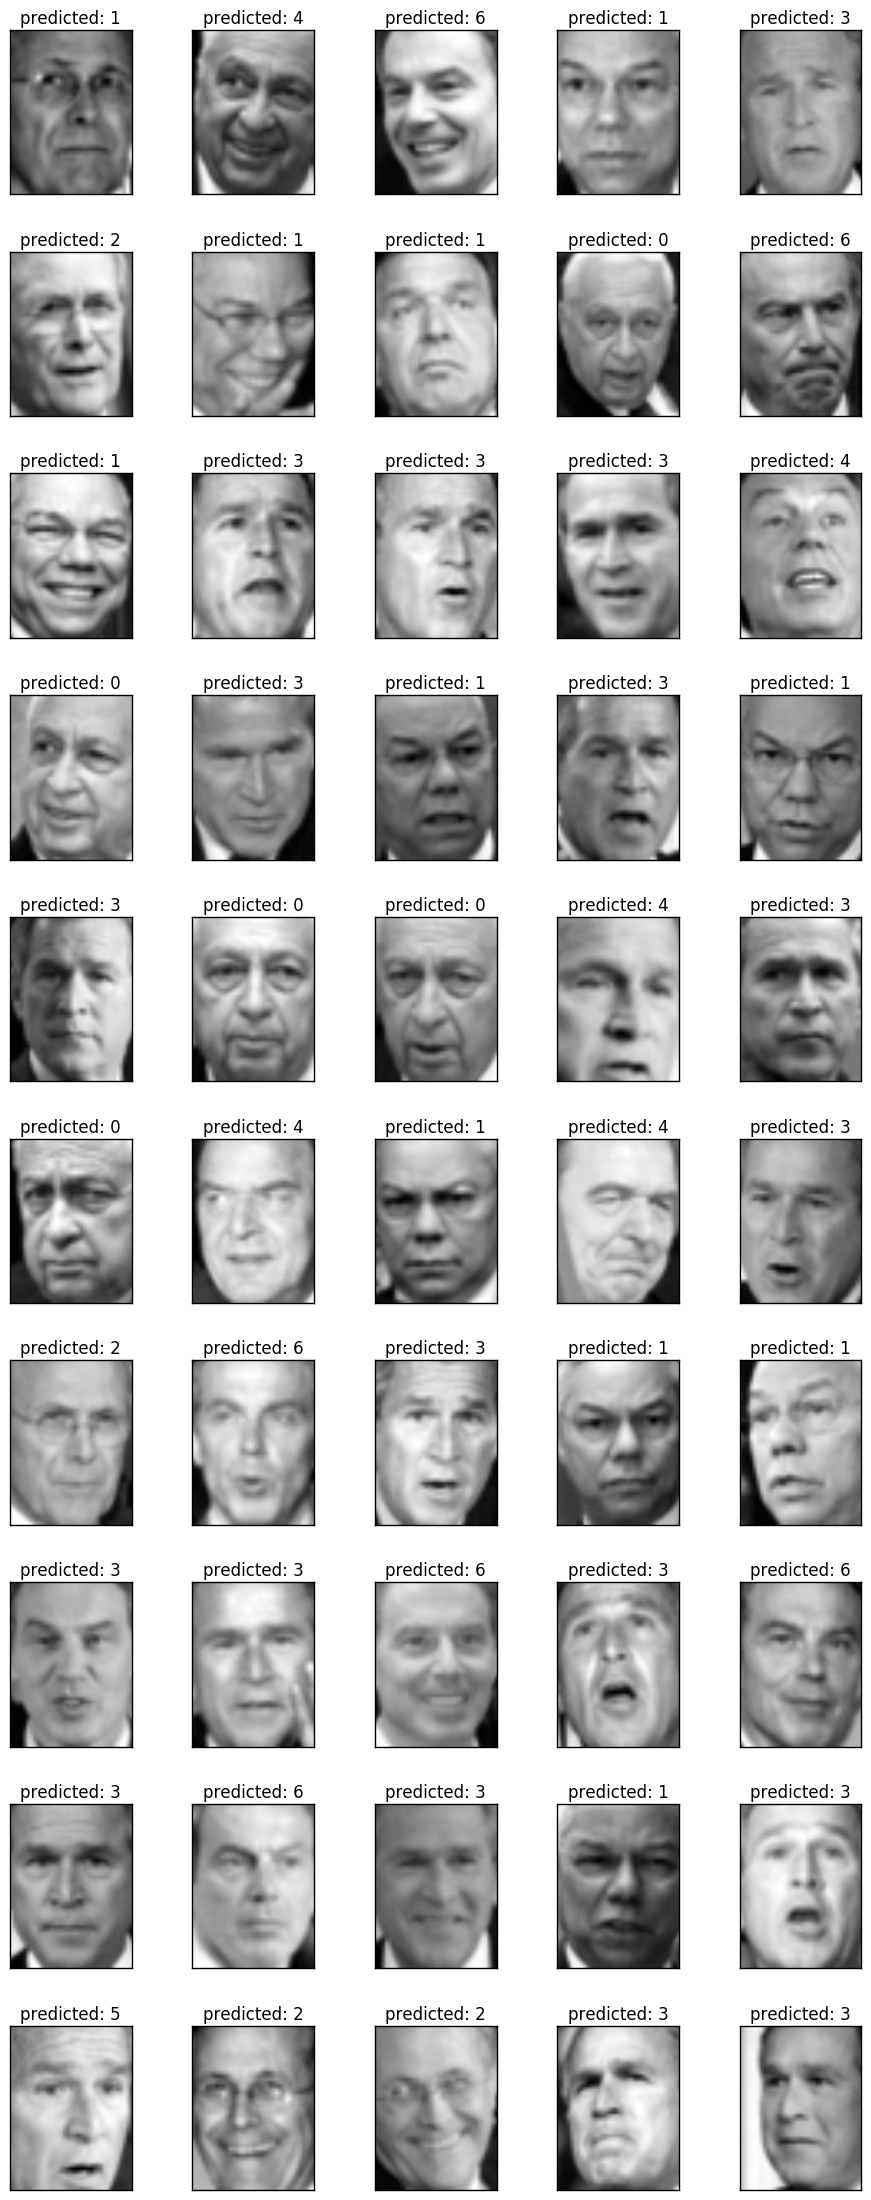

In [23]:
prediction_titles = [title(classes_unaligned, i) for i in range(classes_unaligned.shape[0])]
plot_gallery(np.load('X_test.npy'), prediction_titles, h, w)
plt.show()

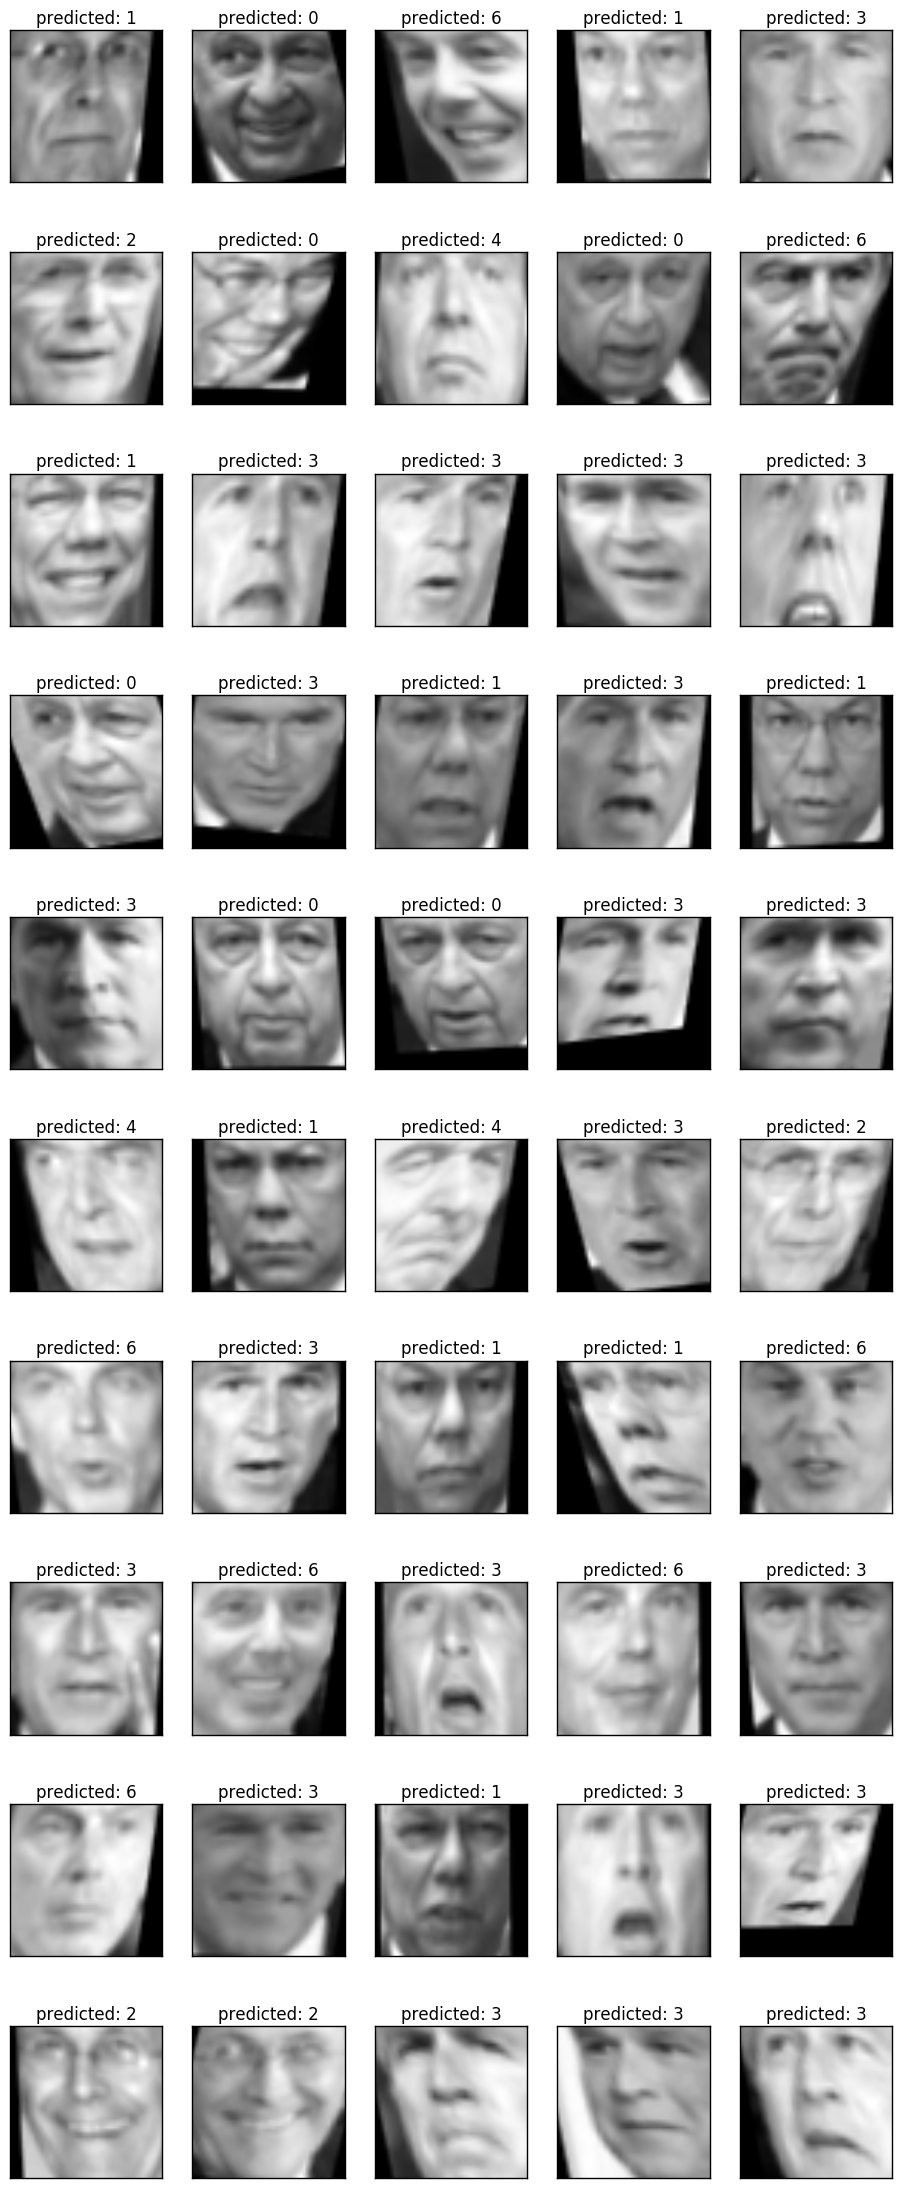

In [26]:
prediction_titles = [title(classes_aligned, i) for i in range(classes_aligned.shape[0])]
plot_gallery(np.load('X_test_aligned.npy'), prediction_titles, aligned_h, aligned_w)
plt.show()

In [55]:
# Retrieved from aligning the images, these are the indices of images where no face was detected
idx_no_face = [25, 85, 104, 106, 125, 131, 180, 202, 211, 233, 238, 244, 279, 283, 304, 309]

updated_classes = classes_aligned.tolist()
updated_prob = prob_aligned.tolist()

# Insert placeholder "None" to indicate that no class was derived for images with no face detected
for i in idx_no_face:
    updated_classes.insert(i, None)
    updated_prob.insert(i, None)

In [53]:
def get_max(lst):
    if lst:
        return max(lst), lst.index(max(lst))
    else:
        return None, None

final_classes = []

# Find the predicted class with the highest probability from the 2 model predictions
for idx, (unaligned_prob, aligned_prob) in enumerate(zip(prob_unaligned, updated_prob)):
    unaligned_highest_prob, unaligned_class = get_max(unaligned_prob.tolist())
    aligned_highest_prob, aligned_class = get_max(aligned_prob)
    
    if aligned_highest_prob is None or unaligned_highest_prob > aligned_highest_prob:
        final_classes.append(unaligned_class)
    elif aligned_highest_prob >= unaligned_highest_prob:
        final_classes.append(aligned_class)
    else:
        print(idx, unaligned_highest_prob, unaligned_class, aligned_highest_prob, aligned_class)
        
print(final_classes)

[1, 0, 6, 1, 3, 2, 0, 4, 0, 6, 1, 3, 3, 3, 4, 0, 3, 1, 3, 1, 3, 0, 0, 3, 3, 0, 4, 1, 4, 3, 2, 6, 3, 1, 1, 6, 3, 6, 3, 6, 3, 6, 3, 1, 3, 3, 2, 2, 3, 3, 3, 6, 3, 3, 4, 2, 1, 5, 4, 0, 6, 4, 2, 2, 4, 3, 1, 3, 3, 3, 2, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 6, 3, 6, 2, 1, 1, 2, 1, 0, 4, 2, 3, 6, 3, 3, 1, 1, 3, 3, 6, 3, 3, 2, 4, 3, 6, 2, 4, 3, 3, 0, 0, 3, 3, 6, 5, 2, 3, 2, 0, 5, 3, 6, 3, 5, 0, 2, 4, 3, 5, 3, 1, 1, 3, 1, 2, 3, 3, 1, 6, 1, 3, 3, 1, 6, 2, 3, 3, 3, 4, 4, 1, 6, 3, 5, 1, 3, 3, 1, 3, 3, 0, 5, 4, 6, 2, 3, 5, 3, 2, 2, 3, 1, 1, 2, 3, 3, 3, 5, 3, 1, 4, 0, 6, 3, 1, 3, 5, 1, 5, 6, 3, 3, 3, 2, 3, 1, 4, 3, 2, 3, 3, 3, 2, 3, 3, 1, 4, 0, 0, 6, 6, 2, 1, 3, 2, 3, 3, 1, 6, 2, 3, 6, 6, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 2, 6, 2, 6, 3, 5, 2, 3, 3, 3, 3, 1, 6, 5, 3, 1, 0, 1, 0, 1, 1, 0, 1, 2, 3, 1, 3, 3, 3, 3, 4, 1, 3, 0, 1, 3, 4, 3, 3, 3, 6, 1, 1, 1, 3, 3, 3, 6, 4, 3, 0, 2, 3, 3, 3, 3, 6, 3, 6, 3, 2, 3, 1, 1, 0, 1, 2, 3, 1, 3, 4, 3, 3, 1, 3, 2, 3, 0, 3, 0, 3, 1, 3, 3, 3, 1]


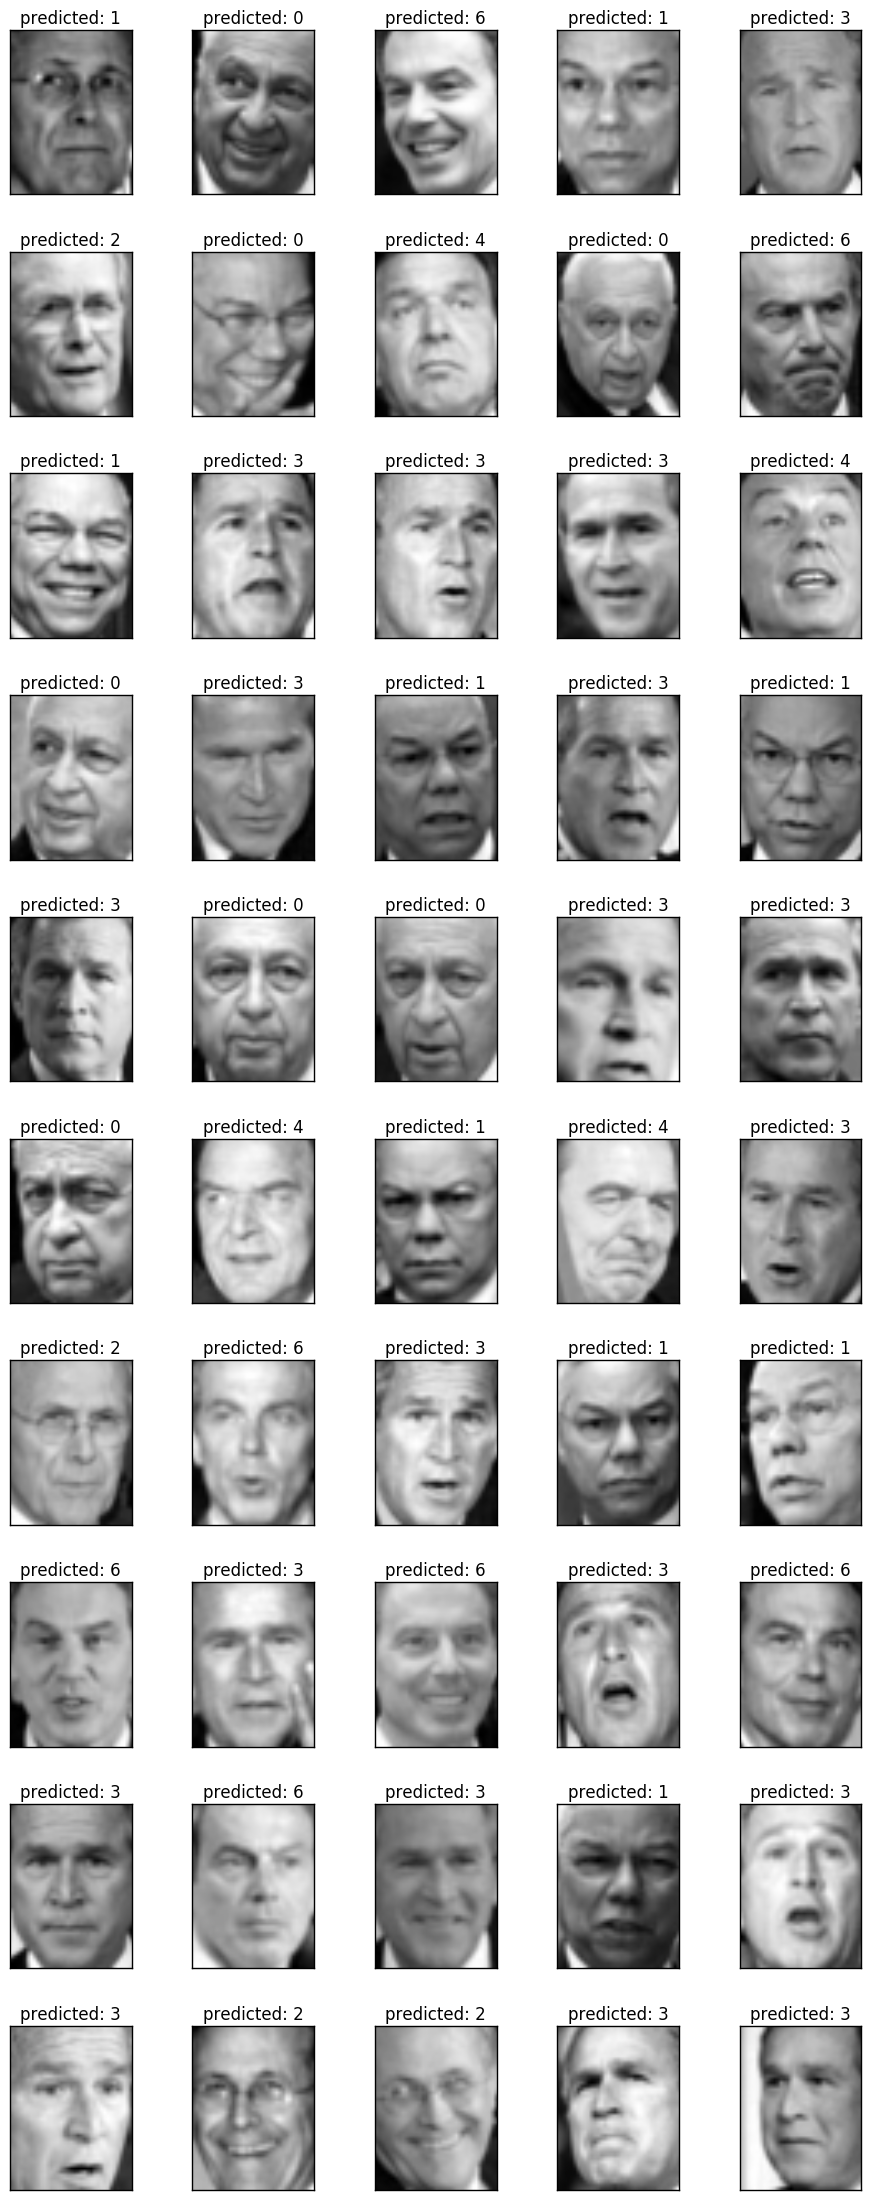

In [43]:
prediction_titles = [title(final_classes, i) for i in range(len(final_classes))]
plot_gallery(np.load('X_test.npy'), prediction_titles, h, w)
plt.show()

In [58]:
with open("predictions.csv", "w") as f:
    f.write("ImageId,PredictedClass")
    for idx, label in enumerate(final_classes):
        f.write("\n{0},{1}".format(idx, label))